# House Prices: Advanced Regression Techniques - Part IV

In this notebook we will only work with the GradientBoostingRegressor().
We will primarily do feature engineering in conjunction with more rigorous EDA.

In [11]:
from load_modules_files_functions_clean import *
import warnings
warnings.filterwarnings('ignore')

In [12]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,3,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,3,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,3,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,3,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,3,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


Define functions that have been problematic or that have to be redefined. 

In [13]:
def get_train_val_sets(X, y, cols, test_size = 0.20):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = test_size, random_state = 1)
    return X_train[cols], X_val[cols], y_train, y_val

def print_cv_val_score(my_s, print_best_est = True, adj_refit = False): # This function does not work properly when it is imported from load_modules_files_functions_clean; X[cols] is not updated correctly.   
    best_est = my_s.best_estimator_
    best_est.fit(X_train, y_train)       
    if adj_refit:
        best_idx = my_s.best_index_
        best_adj_CV_score = my_s.cv_results_['mean_test_score'][best_idx] - my_s.cv_results_['std_test_score'][best_idx]
        print('Best adjusted CV score:', round(-best_adj_CV_score, 5))
    else:
        best_CV_score = my_s.best_score_        
        print('Best CV score:', round(-best_CV_score, 5))
    if y_val.shape[0] > 0:
        y_pred = best_est.predict(X_val)
        val_score = rmsle(y_val, y_pred)
        print('Validation score:', round(val_score, 5))
    if print_best_est:
        print(best_est)
        
def get_sub_csv(my_s, cols, name_csv): # There is a similar problem for this function as well.
    print(name_csv)
    best_est = my_s.best_estimator_    
    best_est.fit(X[cols], y)
    X_test = test[cols]
    y_pred = best_est.predict(X_test)    
    test_submission = pd.DataFrame({'Id':test['Id'], 'SalePrice':y_pred})
    test_submission.to_csv(name_csv, index=False)

def adj_refit_fn(cv_results):
    best_score_idx = np.argmax(cv_results['mean_test_score'] - cv_results['std_test_score'])    
    return(best_score_idx)

def load_run_save_GSCV(key, param_grid, save_s = True, adj_refit = False, cv = 5):
    global results
    best_CV_score = np.nan
    val_score= np.nan
    filename = key + '.joblib'
    if os.path.isfile(filename):
        my_s = joblib.load(filename)
    else:
        if adj_refit:
            my_refit = adj_refit_fn
        else:
            my_refit = True
        my_s = GridSearchCV(ttr, param_grid = param_grid, cv = cv, scoring = rmsle_scorer, n_jobs = -1, verbose = 10, error_score = 'raise', refit = my_refit)
        my_s = my_s.fit(X_train, y_train)
        if save_s:
            joblib.dump(my_s, filename)
    best_est = my_s.best_estimator_
    best_est.fit(X_train, y_train)   
    
    if y_val.shape[0] > 0:
        y_pred = best_est.predict(X_val)
        val_score = rmsle(y_val, y_pred)
    if adj_refit:
        best_idx = my_s.best_index_
        best_adj_CV_score = my_s.cv_results_['mean_test_score'][best_idx] - my_s.cv_results_['std_test_score'][best_idx]
        print('Best adjusted CV score:', round(-best_adj_CV_score, 5))
    else:
        best_CV_score = my_s.best_score_        
        print('Best CV score:', round(-best_CV_score, 5))
    if y_val.shape[0] > 0:
        print('Validation score:', round(val_score, 5))      
        
    results_model = pd.Series({'Best CV score': -best_CV_score, 'Val score':val_score})
    results_model.name = key
    results = results.append(results_model)
    return my_s

def min_imp_filter(cols, feat_imps, min_imp):
    feats_keep = list(feat_imps[feat_imps > min_imp].index)
    cols_keep = []
    for col in cols:
        if col in feats_keep:
            cols_keep.append(col)
    return cols_keep

## EDA

Plot the distribution of the target variable.

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

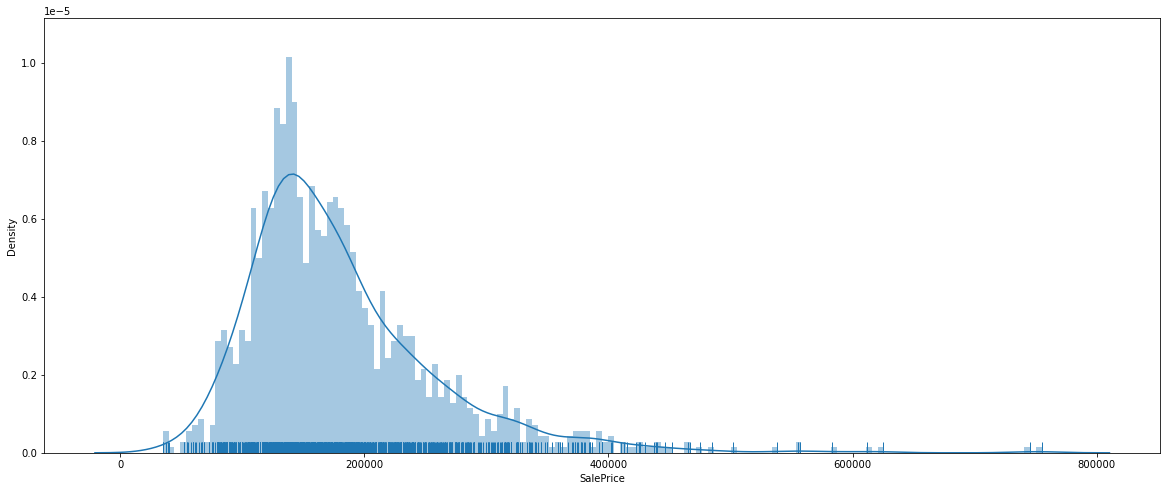

In [14]:
plt.figure(figsize = (20, 8))
sns.distplot(y, rug = True, kde = True, bins=150)

**Comments:** 
* There are a couple of outliers that may worsen the performance of the models. Should they be removed from the train data?
* Perhaps plot the distribution of the target variable in the train and validation data sets? 

Plot distribution of numerical features and numerical features versus target.

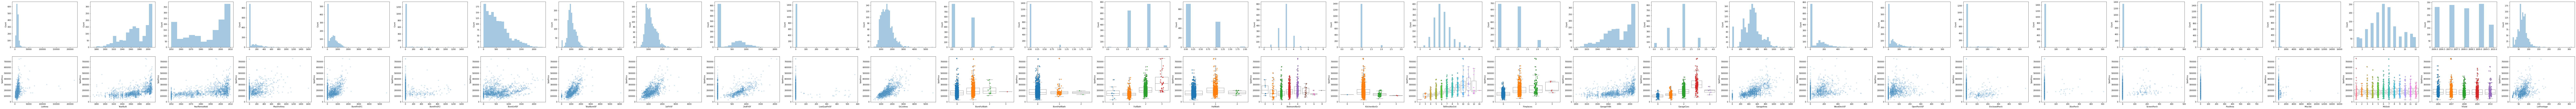

In [15]:
fig, axes = plt.subplots(2, len(num_cols), figsize = (250, 10))
for i, col in enumerate(num_cols):
    sns.distplot(X[col], ax = axes[0, i], kde = False)
    axes[0, i].set(xlabel = '', ylabel = 'Count')
    if col in ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold']:
        sns.boxplot(data = pd.concat([X[num_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], color = 'white')
        sns.stripplot(data = pd.concat([X[num_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i])
    else:
        sns.scatterplot(data = pd.concat([X[num_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], alpha = 0.2)
    
        

Plot distribution of numerical features and numerical features versus target with regression.

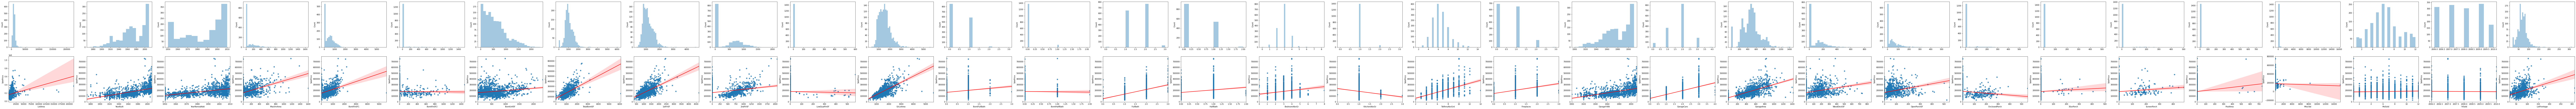

In [16]:
fig, axes = plt.subplots(2, len(num_cols), figsize = (250, 10))
for i, col in enumerate(num_cols):
    sns.distplot(X[col], ax = axes[0, i], kde = False)
    axes[0, i].set(xlabel = '', ylabel = 'Count')
    sns.regplot(data = pd.concat([X[num_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], line_kws = {"color": "red"})

Plot distribution of ordinal features and ordinal features versus target.

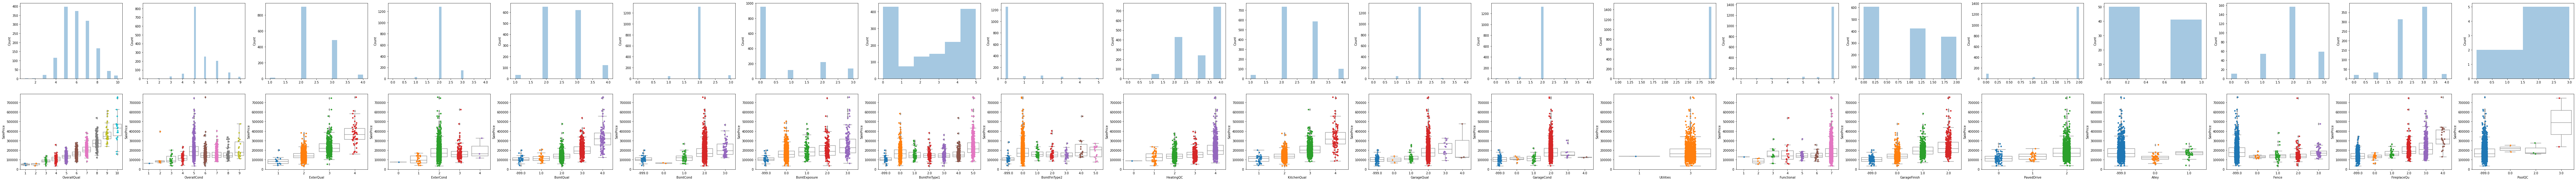

In [17]:
fig, axes = plt.subplots(2, len(ord_cols), figsize = (150, 10))
for i, col in enumerate(ord_cols):
    sns.distplot(X[col], ax = axes[0, i], kde = False)
    axes[0, i].set(xlabel = '', ylabel = 'Count')
    sns.stripplot(data = pd.concat([X[ord_cols].fillna(-999), y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], jitter = 1)    
    sns.boxplot(data = pd.concat([X[ord_cols].fillna(-999), y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], color = 'white') 

Plot distribution of categorical features and categorical features versus target.

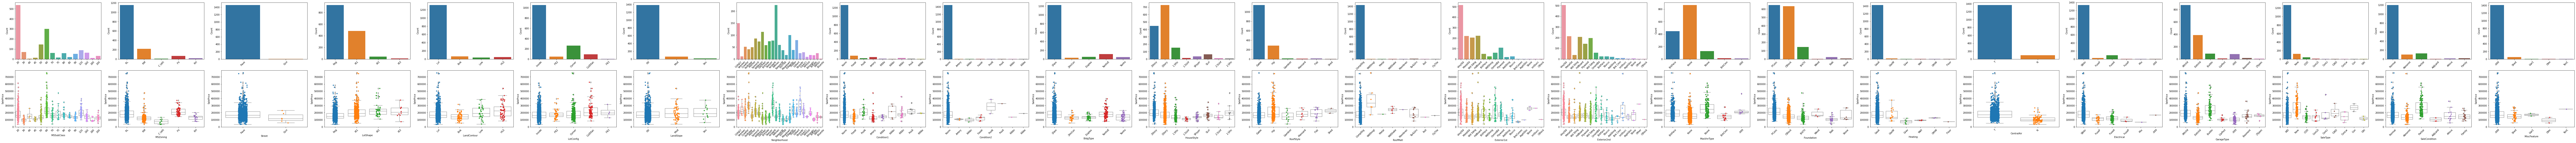

In [18]:
fig, axes = plt.subplots(2, len(cat_cols), figsize = (200, 10))
for i, col in enumerate(cat_cols):
    g = sns.countplot(X[col].fillna(-999), ax = axes[0, i])
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)
    axes[0, i].set(xlabel = '', ylabel = 'Count')
    g = sns.stripplot(data = pd.concat([X[cat_cols].fillna(-999), y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], jitter = True)
    g = sns.boxplot(data = pd.concat([X[cat_cols].fillna(-999), y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], color = 'white')
    g.set_xticklabels(g.get_xticklabels(), rotation = 45)

## Models

We begin by recreating the best performing models so far.

Define the dataframe where the results for the different models are stored.

In [19]:
results = pd.DataFrame({'Best CV score':[], 'Val score':[]}) 

We make sure we get the train and validation sets in the right format.

In [20]:
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + ord_cols + cat_cols)
X_train, X_val, y_train, y_val = pd.concat([X_train, X_val], axis = 0), pd.DataFrame(), pd.concat([y_train, y_val]), pd.DataFrame() # Put all observations in X in X_train, but keep the same shuffling.

Build pipeline with OneHotEndcoder() for the categorical features.

In [21]:
imputer = ColumnTransformer([
    ('imputer_num_cols', 'passthrough', slice(0, len(num_cols))),
    ('imputer_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols))),
    ('imputer_cat_cols', 'passthrough' , slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols))) 
])

preprocessor = ColumnTransformer([
            ('scaler_num_cols', 'passthrough', slice(0, len(num_cols))),
            ('scaler_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols))),
            ('category_encoder_cat_cols', OneHotEncoder(handle_unknown = 'ignore'), slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
]) 

steps = [
    ('imputer', imputer),
    ('preprocessor', preprocessor),         
    ('model', None)
]

pipeline = Pipeline(steps)

ttr = TransformedTargetRegressor(regressor = pipeline, func = np.log1p, inverse_func = np.expm1)

Define a param_grid where different imputation strategies for the categorical features are considered.

In [22]:
gbr = GradientBoostingRegressor(random_state = 1)

param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_num_cols__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_ord_cols__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value = 'MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': ['most_frequent', 'constant'],    
    'regressor__model': [gbr],
}

key = 'gbr_default_cat'
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = True)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 6)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 10)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 3)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 7)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 8)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 9)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = True, cv = 8)

In [23]:
#print_cv_val_score(my_s, print_best_est = False, adj_refit = True)

In [24]:
#my_s.best_estimator_.regressor_.named_steps

In [25]:
#name = 'gbr_sub_num_ord_cat.csv'
#get_sub_csv(my_s, num_cols + ord_cols + cat_cols, name)

Plot feature importances (including OHE features).

In [26]:
#ohe = my_s.best_estimator_.regressor_.named_steps.preprocessor.named_transformers_.category_encoder_cat_cols
#model = my_s.best_estimator_.regressor_.named_steps.model
#feat_imps = pd.Series(model.feature_importances_, index = list(X[num_cols + ord_cols].columns) + list(ohe.get_feature_names(cat_cols)))
#plt.figure(figsize = (105, 10))
#feat_imps.sort_values(ascending = False).plot(kind='bar', rot = 60)

In [27]:
#print('No. features after OHE:', len(model.feature_importances_))
#print('No. features after OHE larger than 0:', len(model.feature_importances_[model.feature_importances_ > 0]))

## Feature Engineering

We begin by only considering num_cols.

### Add new features.

In [28]:
X['DiffYearRemodAddBuilt'] = X['YearRemodAdd'] - X['YearBuilt']
test['DiffYearRemodAddBuilt'] = test['YearRemodAdd'] - test['YearBuilt']

X['DivGrLivAreaFullBath'] = X['GrLivArea'] / X['FullBath']
test['DivGrLivAreaFullBath'] = test['GrLivArea'] / test['FullBath']

X['DivGrLivAreaBedroomAbvGr'] = X['GrLivArea'] / X['BedroomAbvGr']
test['DivGrLivAreaBedroomAbvGr'] = test['GrLivArea'] / test['BedroomAbvGr']

X['DivGrLivAreaTotRmsAbvGrd'] = X['GrLivArea'] / X['TotRmsAbvGrd']
test['DivGrLivAreaTotRmsAbvGrd'] = test['GrLivArea'] / test['TotRmsAbvGrd']

X = X.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)

X['MulGrLivAreaFullBath'] = X['GrLivArea'] * X['FullBath']
test['MulGrLivAreaFullBath'] = test['GrLivArea'] * test['FullBath']

Only consider cases where FullBath == 1 or FullBath == 2 

In [29]:
X['DivGrLivAreaFullBath1'] = np.where(X['FullBath'] == 1, X['DivGrLivAreaFullBath'], np.nan)
test['DivGrLivAreaFullBath1'] = np.where(test['FullBath'] == 1, test['DivGrLivAreaFullBath'], np.nan)

X['DivGrLivAreaFullBath2'] = np.where(X['FullBath'] == 2, X['DivGrLivAreaFullBath'], np.nan)
test['DivGrLivAreaFullBath2'] = np.where(test['FullBath'] == 2, test['DivGrLivAreaFullBath'], np.nan)

In [30]:
#num_cols.append('DiffYearRemodAddBuilt')
#num_cols.remove('YearRemodAdd')
#num_cols.remove('YearBuilt')

#num_cols.append('DivGrLivAreaFullBath')
#num_cols.remove('FullBath')
#num_cols.remove('GrLivArea')

#num_cols.append('DivGrLivAreaFullBath1')
#num_cols.append('DivGrLivAreaFullBath2')

#num_cols.append('DivGrLivAreaBedroomAbvGr')

#num_cols.append('DivGrLivAreaTotRmsAbvGrd') # Keep

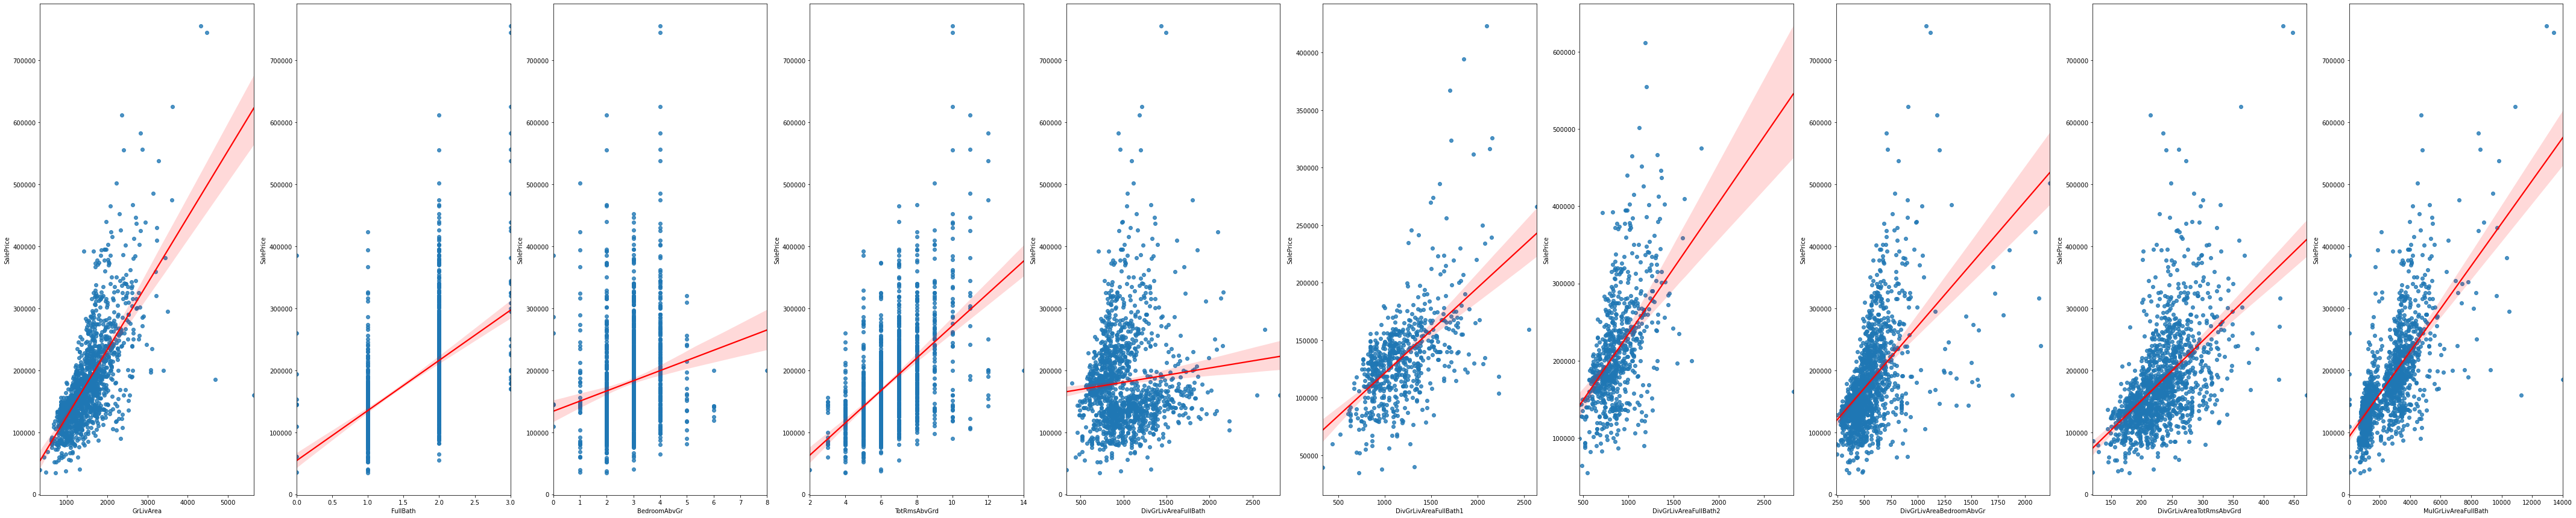

In [31]:
#plot_cols = ['YearBuilt', 'YearRemodAdd', 'DiffYearRemodAddBuilt']
plot_cols = ['GrLivArea', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd', 'DivGrLivAreaFullBath', 'DivGrLivAreaFullBath1', 'DivGrLivAreaFullBath2', 'DivGrLivAreaBedroomAbvGr', 'DivGrLivAreaTotRmsAbvGrd', 'MulGrLivAreaFullBath']#

cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
fig, axes = plt.subplots(1, len(plot_cols), figsize = (75, 15))
for i, col in enumerate(plot_cols):
    #sns.scatterplot(data = pd.concat([X[plot_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes.flat[i], alpha = 0.75, hue = 'FullBath', style = 'FullBath', palette = "Set2")
    #sns.scatterplot(data = pd.concat([X[plot_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes.flat[i], alpha = 0.75, hue = 'BedroomAbvGr', style = 'BedroomAbvGr', palette = "Set2")
    sns.regplot(data = pd.concat([X[plot_cols].replace([np.inf, -np.inf], np.nan), y], axis = 1), x = col, y = 'SalePrice', ax = axes.flat[i],  line_kws = {"color": "red"}) 

**Comment:** 
* There seems to be two linear regimes for DivGrLivAreaFullBath.
* In the distribution of FullBath, 1 and 2 dominate completely.

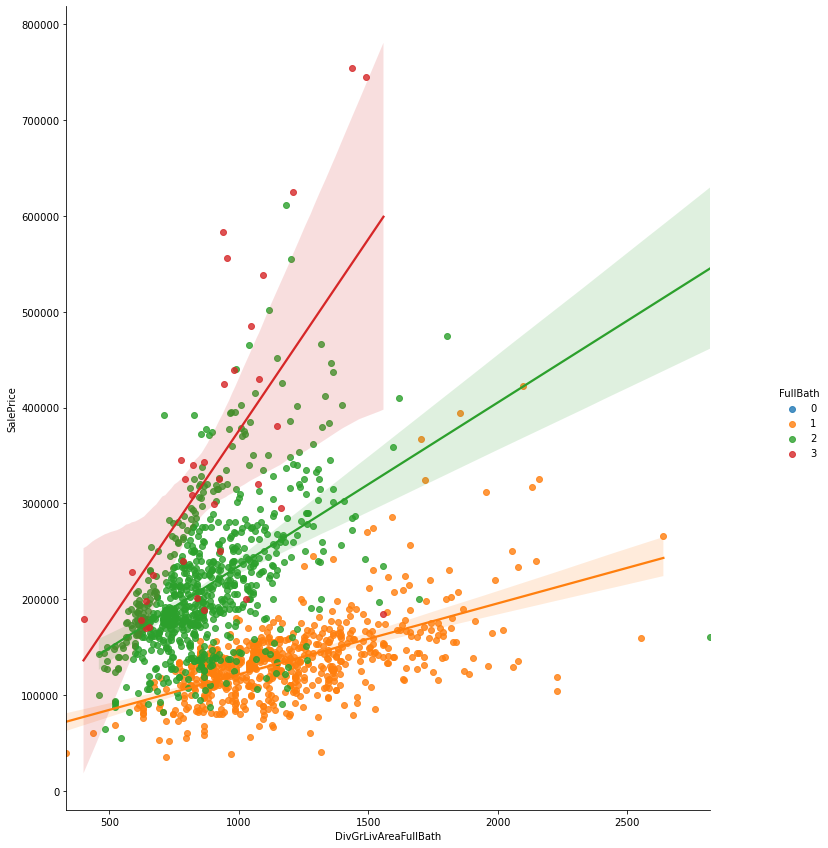

In [32]:
g = sns.lmplot(data = pd.concat([X[plot_cols].replace([np.inf, -np.inf], np.nan), y], axis = 1), x = 'DivGrLivAreaFullBath', y = 'SalePrice', hue = 'FullBath')
g.fig.set_size_inches(12.5, 12.5)

In [33]:
X['TotalBath'] = X['BsmtFullBath'] + X['BsmtHalfBath'] + X['FullBath'] + X['HalfBath']
test['TotalBath'] = test['BsmtFullBath'] + test['BsmtHalfBath'] + test['FullBath'] + test['HalfBath']

X['TotRmsAbvGrdPlusTotalBath'] = X['TotRmsAbvGrd'] + X['TotalBath']
test['TotRmsAbvGrdPlusTotalBath'] = test['TotRmsAbvGrd'] + test['TotalBath']

Plot the new features.

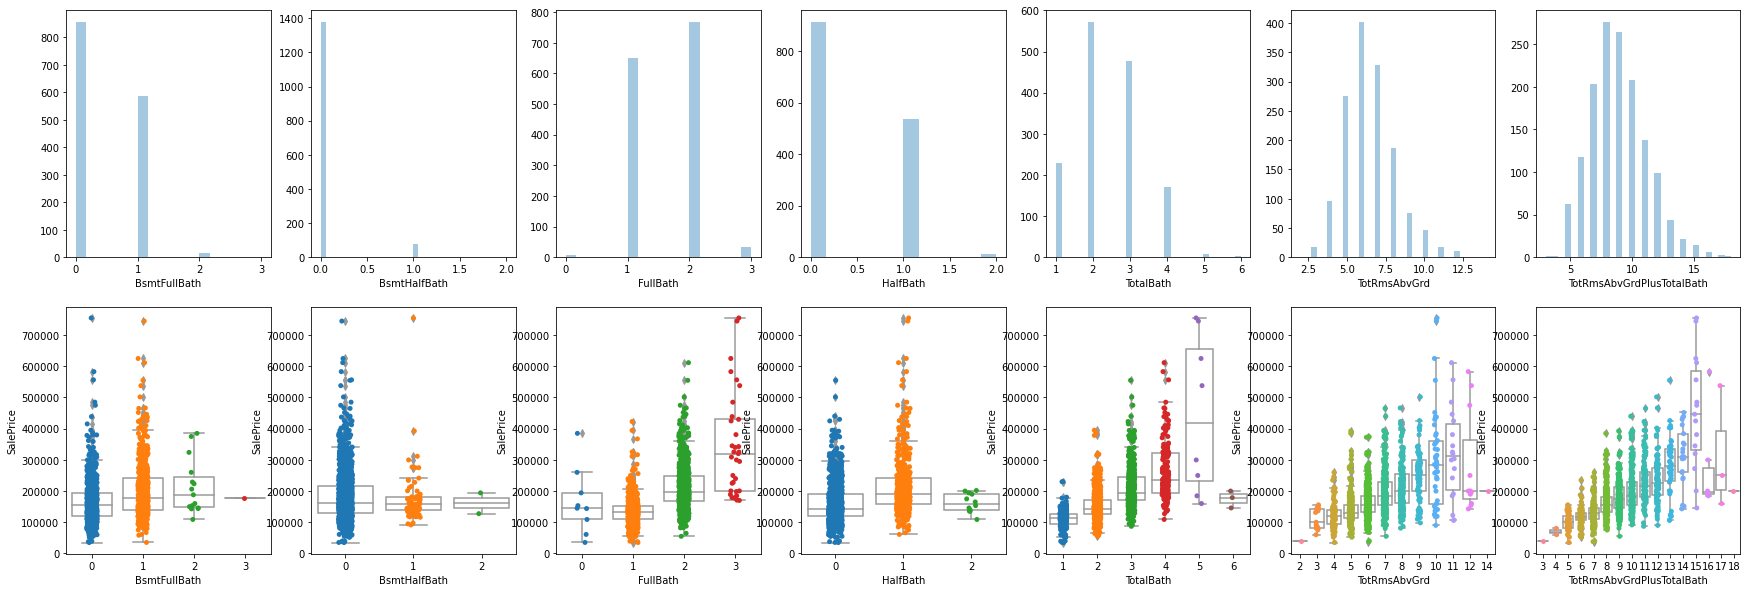

In [34]:
plot_cols = ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotalBath', 'TotRmsAbvGrd', 'TotRmsAbvGrdPlusTotalBath']
fig, axes = plt.subplots(2, len(plot_cols), figsize = (30, 10))
for i, col in enumerate(plot_cols):
    sns.distplot(X[col], ax = axes[0, i], kde = False)
    sns.boxplot(data = pd.concat([X[plot_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i], color = 'white')
    sns.stripplot(data = pd.concat([X[plot_cols], y], axis = 1), x = col, y = 'SalePrice', ax = axes[1, i])    

**Comment:** It could be a good idea to add TotalBath and/or TotTotRmsAbvGrdPlusTotalBath.

In [35]:
#num_cols.append('TotalBath') 
#num_cols.remove('BsmtFullBath')
#num_cols.remove('BsmtHalfBath')
#num_cols.remove('FullBath')
#num_cols.remove('HalfBath')

#num_cols.append('TotRmsAbvGrdPlusTotalBath')

#num_cols.remove('TotRmsAbvGrdPlusTotalBath')
#num_cols.remove('TotRmsAbvGrd')

#num_cols[num_cols.index('TotRmsAbvGrd')] = 'TotRmsAbvGrdPlusTotalBath'

### Modify already existing features.

In [36]:
X['BsmtFinSF2Binary'] = 0
X.loc[X['BsmtFinSF2'] > 0, 'BsmtFinSF2Binary'] = 1

X['LowQualFinSFBinary'] = 0
X.loc[X['LowQualFinSF'] > 0, 'LowQualFinSFBinary'] = 1
test['LowQualFinSFBinary'] = 0
test.loc[test['LowQualFinSF'] > 0, 'LowQualFinSFBinary'] = 1

X['BsmtFullBathBinned'] = X['BsmtFullBath']
X.loc[X['BsmtFullBath'] == 3, 'BsmtFullBathBinned'] = 2
test['BsmtFullBathBinned'] = test['BsmtFullBath']
test.loc[test['BsmtFullBath'] == 3, 'BsmtFullBathBinned'] = 2

X['BsmtFullBathBinary'] = X['BsmtFullBath']
X.loc[X['BsmtFullBath'].isin([1, 2, 3]), 'BsmtFullBathBinary'] = 1

X['BsmtHalfBathBinary'] = 0
X.loc[X['BsmtHalfBath'] > 0, 'BsmtHalfBathBinary'] = 1
test['BsmtHalfBathBinary'] = 0
test.loc[test['BsmtHalfBath'] > 0, 'BsmtHalfBathBinary'] = 1

X['FullBathBinned'] = X['FullBath']
X.loc[X['FullBath'] == 0, 'FullBathBinned'] = 1

X['HalfBathBinary'] = X['HalfBath']
X.loc[X['HalfBath'] == 2, 'HalfBathBinary'] = 1

X['BedroomAbvGrBinned'] = X['BedroomAbvGr']
X.loc[X['BedroomAbvGrBinned'] >= 5, 'BedroomAbvGrBinned'] = 5

X['KitchenAbvGrBinned'] = X['KitchenAbvGr']
X.loc[X['KitchenAbvGrBinned'] == 0, 'KitchenAbvGrBinned'] = 1
X.loc[X['KitchenAbvGrBinned'] == 3, 'KitchenAbvGrBinned'] = 2
test['KitchenAbvGrBinned'] = test['KitchenAbvGr']
test.loc[test['KitchenAbvGrBinned'] == 0, 'KitchenAbvGrBinned'] = 1
test.loc[test['KitchenAbvGrBinned'] == 3, 'KitchenAbvGrBinned'] = 2

X['TotRmsAbvGrdBinned'] = X['TotRmsAbvGrd']
X.loc[X['TotRmsAbvGrdBinned'] >= 11, 'TotRmsAbvGrdBinned'] = 11
test['TotRmsAbvGrdBinned'] = test['TotRmsAbvGrd']
test.loc[test['TotRmsAbvGrdBinned'] >= 11, 'TotRmsAbvGrdBinned'] = 11

X['FireplacesBinned'] = X['Fireplaces']
X.loc[X['FireplacesBinned'] >= 2, 'FireplacesBinned'] = 2

X['GarageCarsBinned'] = X['GarageCars']
X.loc[X['GarageCarsBinned'] >= 3, 'GarageCarsBinned'] = 3
test['GarageCarsBinned'] = test['GarageCars']
test.loc[test['GarageCarsBinned'] >= 3, 'GarageCarsBinned'] = 3

X['EnclosedPorchBinary'] = X['EnclosedPorch']
X.loc[X['EnclosedPorchBinary'] > 0, 'EnclosedPorchBinary'] = 1

X['3SsnPorchBinary'] = X['3SsnPorch']
X.loc[X['3SsnPorchBinary'] > 0, '3SsnPorchBinary'] = 1
test['3SsnPorchBinary'] = test['3SsnPorch']
test.loc[test['3SsnPorchBinary'] > 0, '3SsnPorchBinary'] = 1

X['MiscValBinary'] = X['MiscVal']
X.loc[X['MiscValBinary'] > 0, 'MiscValBinary'] = 1

In [37]:
#print(X['MiscVal'].value_counts().sort_index())
#X['MiscValBinary'].value_counts().sort_index()

In [38]:
#num_cols[num_cols.index('BsmtFinSF2')] = 'BsmtFinSF2Binary'

num_cols[num_cols.index('LowQualFinSF')] = 'LowQualFinSFBinary' # Keep

#num_cols[num_cols.index('BsmtFullBath')] = 'BsmtFullBathBinned' # Keep

#num_cols[num_cols.index('BsmtFullBath')] = 'BsmtFullBathBinary'

#num_cols[num_cols.index('BsmtHalfBath')] = 'BsmtHalfBathBinary' # Keep

#num_cols[num_cols.index('FullBath')] = 'FullBathBinned'

#num_cols[num_cols.index('HalfBath')] = 'HalfBathBinary'

#num_cols[num_cols.index('BedroomAbvGr')] = 'BedroomAbvGrBinned'

#num_cols[num_cols.index('KitchenAbvGr')] = 'KitchenAbvGrBinned' # Keep

#num_cols[num_cols.index('TotRmsAbvGrd')] = 'TotRmsAbvGrdBinned' # Keep

#num_cols[num_cols.index('Fireplaces')] = 'FireplacesBinned'

#num_cols[num_cols.index('GarageCars')] = 'GarageCarsBinned' # Keep

#num_cols[num_cols.index('EnclosedPorch')] = 'EnclosedPorchBinary'

#num_cols[num_cols.index('3SsnPorch')] = '3SsnPorchBinary' # Keep

#num_cols[num_cols.index('ScreenPorch')] = 'ScreenPorchBinary'

#num_cols[num_cols.index('PoolArea')] = 'PoolAreaBinary'

#num_cols[num_cols.index('MiscVal')] = 'MiscValBinary'

It's probably not worth performing FE on ord_cols (after all that time spent on num_cols).
It might however be a good idea to try FE on cat_cols since we reduce the no. features obtained after OHE.

In [39]:
X['Foundation'] = X['Foundation'].replace({'Wood':'WoodStone', 'Stone':'WoodStone'})
test['Foundation'] = test['Foundation'].replace({'Wood':'WoodStone', 'Stone':'WoodStone'})

We must get new train and validation sets that take into account the updated cols.

In [40]:
X_train, X_val, y_train, y_val = get_train_val_sets(X, y, num_cols + ord_cols + cat_cols)
X_train, X_val, y_train, y_val = pd.concat([X_train, X_val], axis = 0), pd.DataFrame(), pd.concat([y_train, y_val]), pd.DataFrame()

Rebuild the pipeline. 

In [41]:
imputer = ColumnTransformer([
    ('imputer_num_cols', 'passthrough', slice(0, len(num_cols))),
    ('imputer_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols))),
    ('imputer_cat_cols', 'passthrough' , slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols))) 
])

preprocessor = ColumnTransformer([
            ('scaler_num_cols', 'passthrough', slice(0, len(num_cols))),
            ('scaler_ord_cols', 'passthrough', slice(len(num_cols), len(num_cols + ord_cols))),
            ('category_encoder_cat_cols', OneHotEncoder(handle_unknown = 'ignore'), slice(len(num_cols + ord_cols), len(num_cols + ord_cols + cat_cols)))
]) 

steps = [
    ('imputer', imputer),
    ('preprocessor', preprocessor),         
    ('model', None)
]

pipeline = Pipeline(steps)

ttr = TransformedTargetRegressor(regressor = pipeline, func = np.log1p, inverse_func = np.expm1)

In [ ]:
gbr = GradientBoostingRegressor(random_state = 1)

param_grid = {
    'regressor__imputer__imputer_num_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_num_cols__strategy': ['mean', 'median', 'most_frequent', 'constant'],
    #'regressor__imputer__imputer_num_cols__strategy': ['constant'],
    'regressor__imputer__imputer_ord_cols': [SimpleImputer(fill_value = -999)],
    'regressor__imputer__imputer_ord_cols__strategy': ['mean', 'median', 'most_frequent', 'constant'],    
    'regressor__imputer__imputer_cat_cols': [SimpleImputer(fill_value = 'MISS')],
    'regressor__imputer__imputer_cat_cols__strategy': ['most_frequent', 'constant'],    
    'regressor__model': [gbr],
}

key = 'gbr_default_cat_FE'
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = True)
#my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False)
my_s = load_run_save_GSCV(key, param_grid, save_s = False, adj_refit = False, cv = 8)

In [ ]:
#print_cv_val_score(my_s, print_best_est = False, adj_refit = True)
print_cv_val_score(my_s, print_best_est = False, adj_refit = False)

In [ ]:
#my_s.best_estimator_.regressor_.named_steps

In [ ]:
ohe = my_s.best_estimator_.regressor_.named_steps.preprocessor.named_transformers_.category_encoder_cat_cols
model = my_s.best_estimator_.regressor_.named_steps.model
feat_imps = pd.Series(model.feature_importances_, index = list(X[num_cols + ord_cols].columns) + list(ohe.get_feature_names(cat_cols)))
plt.figure(figsize = (115, 10))
feat_imps.sort_values(ascending = False).plot(kind='bar', rot = 60)

In [ ]:
name = 'gbr_sub_num_ord_cat_FE.csv'
get_sub_csv(my_s, num_cols + ord_cols + cat_cols, name)

## Mean Target Encoding

Try mean target encoding of categorical features.

In [ ]:
from category_encoders.target_encoder import TargetEncoder
X_train[cat_cols]
te = TargetEncoder(cols = cat_cols)
te.fit_transform(X_train, y_train)
te.transform(X_val)
X[cat_cols].info()

## Log

Raw model with cat_cols (no HPO) ---> CV: 0.12817, Val: 0.12800, Test: 0.13248

**FE** ---> Try adding some new features.

Add DiffYearRemodAddBuilt ---> CV: 0.12919, Val: 0.12837, Test: 0.13369 (worse)

Add DiffYearRemodAddBuilt, remove YearRemodAdd ---> CV: 0.12844, Val: 0.12981 (worse)

Add DiffYearRemodAddBuilt, remove YearBuilt ---> CV: 0.12782, Val: 0.12713, Test: 0.13433 (worse)

Add DiffYearRemodAddBuilt, remove YearRemodAdd, remove YearBuilt ---> CV: 0.12723, Val: 0.12828, Test: 0.13425 (worse)

Add DivGrLivAreaFullBath ---> CV: 0.12734, Val: 0.12499, Test: 0.13433 (worse, even though CV and Val have better score)

Add DivGrLivAreaFullBath, remove FullBath ---> CV: 0.12850, Val: 0.12744, Test: 0.13465 (worse)

Add DivGrLivAreaFullBath, remove GrLivArea ---> CV: 0.12969, Val: 0.13086 (worse)

Add DivGrLivAreaFullBath, remove FullBath and GrLivArea ---> CV: 0.13194, Val: 0.13007 (worse)

Add DivGrLivAreaFullBath1 and DivGrLivAreaFullBath2 ---> CV: 0.12741, Val: 0.12883
**Note:** The GridSearchCV chose 'median' as the strategy in SimpleImputer() for num_cols, which makes no sense.

Add DivGrLivAreaFullBath1 and DivGrLivAreaFullBath2, force strategy = 'constant' for SimpleImputer() for num_cols ---> CV: 0.12834, Val: 0.12632, Test: 0.13391 (worse)

Add DivGrLivAreaBedroomAbvGr ---> CV: 0.12790, Val: 0.12715, Test: 0.13428 (worse)

Add DivGrLivAreaTotRmsAbvGrd ---> CV: 0.12830, Val: 0.12381, Test: 0.13208 (better, so will keep this feature) 
**Note:** This feature probably acts as a proxy for the size of the rooms.

**UPDATE 2020-06-05:** Error discovered in GridSearchCV() - SimpleImputer() for cat_cols returns TypeError when fill_value = -999 and strategy = 'constant' but no error is raised when my_s.fit(X_train, y_train) is called. Solution: Henceforth, set fill_value = 'MISS' for cat_cols and GridSearchCV(error_score = 'raise) in order to detect future problems.

Add DivGrLivAreaTotRmsAbvGrd ---> CV: 0.12806, Val: 0.12962, Test: 0.13329 (better CV score, but worse Val and Test scores...)
**Note:** This shows that the previous FE results are invalid and that our current validation strategy should be re-evaluated.

**Compare the score of three different methods with the raw model without HPO.**

Raw model, 100% train, 0% val ---> CV: 0.12742, Val: -, Test: 0.13560 (worse)

Raw model, 80% train, 20% val, adjusted refit ---> Adj CV: 0.14366, Val: 0.12479, Test: 0.13359 (worse)

Raw model, 100% train, 0% val, adjusted refit ---> Adj CV: 0.13881, Val: -, Test: 0.13498 (worse)

**Note:** These methods performed worse wrt. the test score, but not significantly. The last method has the advantage of only having one metric, which is handy when performing FE.

Experiment with some FE:

Add DivGrLivAreaTotRmsAbvGrd ---> Adj CV: 0.13848, Test: 0.13431 (better, compared with 'Raw model, 100% train, 0% val, adjusted refit')

Add DiffYearRemodAddBuilt ---> Adj CV: 0.13853, Test: 0.13439 (worse)

---> The results obtained with the adjusted CV seem to be in line with previously obtained results. 
We will keep the adjusted CV score with 100% train data and see how it performs.

**FE** ---> Modify already existing features (num_cols).

Replace BsmtFinSF2 with BsmtFinSF2Binary ---> Adj CV: 0.13873 (worse)
**Note:** The order in num_cols matters - the modified feature should replace the feature in the same position. Just shuffling num_cols produces a different score.

Replace LowQualFinSF with LowQualFinSFBinary ---> Adj CV: 0.13836 (better, keep this modification)

Replace BsmtFullBath with BsmtFullBathBinned ---> Adj CV: 0.13836 (the same, so can keep it)

Replace BsmtFullBath with BsmtFullBathBinary ---> Adj CV: 0.13844 (worse)

Replace BsmtHalfBath with BsmtHalfBathBinary ---> Adj CV: 0.13836 (the same, so can keep it)

Replace FullBath with FullBathBinned ---> Adj CV: 0.13844

Replace HalfBath with HalfBathBinary ---> Adj CV: 0.13928 (worse)

Replace BedroomAbvGr with BedroomAbvGrBinned ---> Adj CV: 0.13837 (worse)

Replace KitchenAbvGr with KitchenAbvGrBinned ---> Adj CV: 0.13836 (the same, so can keep it)

Replace TotRmsAbvGrd with TotRmsAbvGrdBinned ---> Adj CV: 0.13833 (better)

Replace Fireplaces with FireplacesBinned ---> Adj CV: 0.13856 (worse)

Replace GarageCars with GarageCarsBinned ---> Adj CV: 0.13809 (better)

Replace EnclosedPorch with EnclosedPorchBinary ---> Adj CV: 0.13854 (worse)

Replace 3SsnPorch with 3SsnPorchBinary ---> Adj CV: 0.13809 (the same, so can keep it)

Replace ScreenPorch with ScreenPorchBinary ---> Adj CV: 0.13931 (worse)

Replace PoolArea with PoolAreaBinary ---> Adj CV: 0.13921 (worse)

Replace MiscVal with MiscValBinary ---> Adj CV: 0.13816 (worse)

**Submit in order to get the test score.**

adj_refit = True ---> Adj CV: 0.13809, Test: 0.13459

adj_refit = False ---> CV 0.12680, Test: 0.13459

**Comment:** These results are rather disappointing as they indicate that all the FE was in vain...

**Start over from the beginning with the local validation.**

We start by looking how the no. folds in GridSearchCV() affects the performance.

Raw model (80% train, 20% val, cv = 5) ---> CV: 0.12817, Val: 0.12800, Test: 0.13248 (benchmark)

Raw model (100% train, cv = 5) ---> CV: 0.12817, Test: 0.13560 (worse)

Raw model (100% train, cv = 3) ---> CV: 0.12898, Test: 0.13253 (worse)

Raw model (100% train, cv = 4) ---> CV: 0.12691, Test: 0.13714 (worse)

Raw model (100% train, cv = 6) ---> CV: 0.12557, Test: 0.13449 (worse)

Raw model (100% train, cv = 7) ---> CV: 0.12341, Test: 0.13248 (same)

Raw model (100% train, cv = 8) ---> CV: 0.12312, Test: 0.13237 (better)

Raw model (100% train, cv = 9) ---> CV: 0.12346, Test: 0.13562 (worse)

Raw model (100% train, cv = 10) ---> CV: 0.12512, Test: 0.13498 (worse)

**Comment:** When 100% of the training data is used, the same performance is obtained when cv = 7, and is even slightly better when cv = 8.
This makes sense since the folds are then of comparable size when 80% of the training data is used and cv = 5.
In the long run it's probably worth using 100% of the training data for GridSearchCV().

Raw model (100% train, cv = 8, adj_refit = True) ---> Adj CV: 0.12312  Test: 0.13237 (same)

**Comment:** Perhaps it is a good idea to use adj_refit = True?

Add DivGrLivAreaTotRmsAbvGrd (100% train, cv = 8, adj_refit = False) ---> CV: 0.12327, Test: 0.13384

Replace GarageCars with GarageCarsBinned TotalBath 0.12339 (worse)

Replace LowQualFinSF with LowQualFinSFBinary (100% train, cv = 8, adj_refit = False) ---> CV: 0.12280, Test: 0.13237 (same, but CV score is better)
**Note:** The local validation seems fairly reliable (better CV score and the test score remains the same), but it's probably not worth continuing with this kind of FE.

**Comment:** Our old FE results are probably invalid...

**Two last simple FE attempts**

Add TotalBath (100% train, cv = 8, adj_refit = False) ---> CV: 0.12369, Test: 0.13275 (worse)

Add TotalBath, remove BsmtFullBath, BsmtHalfBath, FullBath and HalfBath (100% train, cv = 8, adj_refit = False) ---> CV: 0.12369, Test: 0.13379 (worse)
**Note:** TotalBath is the 3rd most important feature.

Add TotRmsAbvGrdPlusTotalBath (100% train, cv = 8, adj_refit = False) ---> CV: 0.12440, Test: 0.13547
**Note:** TotRmsAbvGrdPlusTotalBath is the 7th most important feature.

Add TotRmsAbvGrdPlusTotalBath, remove TotRmsAbvGrd (with no respect to the order) (100% train, cv = 8, adj_refit = False) ---> CV: 0.12475

Add TotRmsAbvGrdPlusTotalBath, remove TotRmsAbvGrd (with respect to the order) (100% train, cv = 8, adj_refit = False) ---> CV: 0.12452, Train: 0.13598

**FE** ---> Modify already existing features (cat_cols).

Modify Foundation (Wood ---> WoodStone, Stone ---> WoodStone) ---> CV: 0.12360, Test: 0.13247 (worse)